In [1]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))


Python: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Numpy: 1.14.3
Pandas: 0.23.0
Matplotlib: 2.2.2
Seaborn: 0.11.1
Scipy: 1.1.0


In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Load the dataset from the csv file using pandas
# Dataset taken from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
data = pd.read_csv('creditcard.csv')

In [11]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [18]:
# Fraction data to reduce computational load,  280k lines reduced to 10%
data = data.sample(frac=0.1, random_state = 1)
# Print the shape of the data
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features
# class = 0 is ordinary transaction, class = 1 is fraudulent
# mean on class feature is really close to 0. More ordinary transactions than fraudulent ones

(28481, 31)
                Time            V1            V2            V3            V4  \
count   28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean    94705.035216     -0.001143     -0.018290      0.000795      0.000350   
std     47584.727034      1.994661      1.709050      1.522313      1.420003   
min         0.000000    -40.470142    -63.344698    -31.813586     -5.266509   
25%     53924.000000     -0.908809     -0.610322     -0.892884     -0.847370   
50%     84551.000000      0.031139      0.051775      0.178943     -0.017692   
75%    139392.000000      1.320048      0.792685      1.035197      0.737312   
max    172784.000000      2.411499     17.418649      4.069865     16.715537   

                 V5            V6            V7            V8            V9  \
count  28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean      -0.015666      0.003634     -0.008523     -0.003040      0.014536   
std        1.395552      1.334

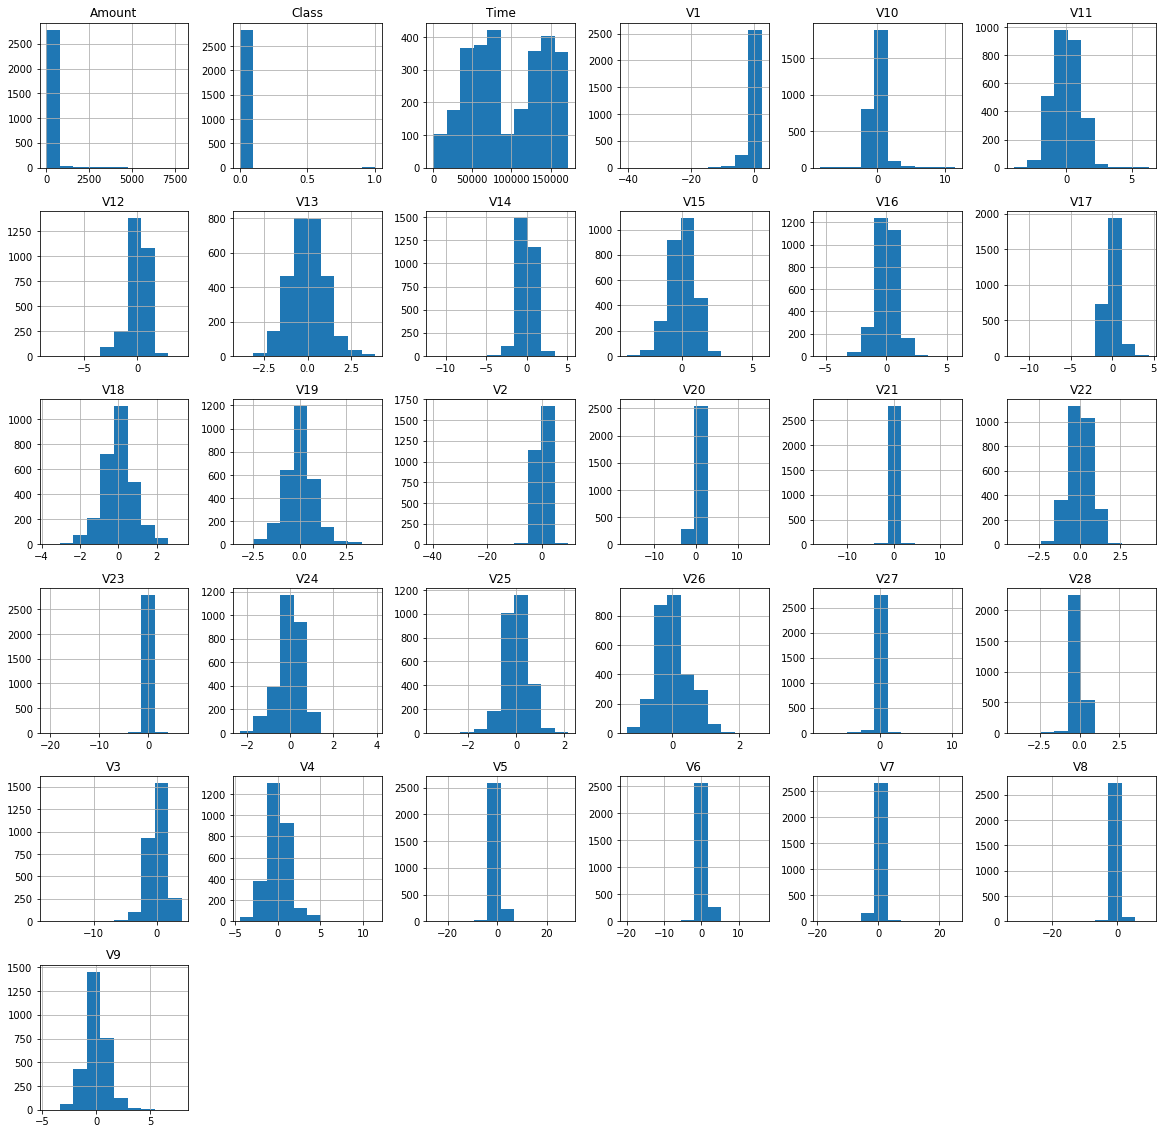

In [14]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [19]:
# Determine number of fraud cases in dataset
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

# used float on the division to avoid rounding
outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(Fraud)))
print('Valid Transactions: {}'.format(len(Valid)))

0.0017234102419808666
Fraud Cases: 49
Valid Transactions: 28432


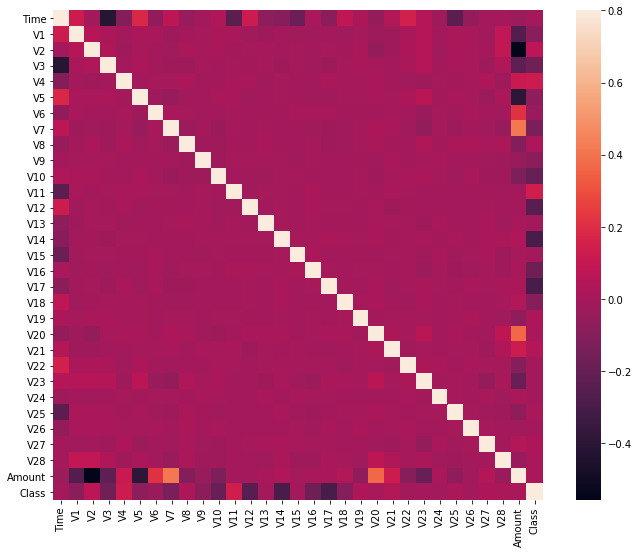

In [21]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

# No 1-1 correlations.
# V11 has strong correlation to Class and V17 has strong negative correlation to Class.

In [22]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove the "Class" feature for prediction
# Unsupervised learning so labels will not be fed ahead of time
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [23]:
from sklearn.metrics import classification_report, accuracy_score
# Isolation Forest Algorithm: Uses random forests to calculate how easy it is to isolate a point
from sklearn.ensemble import IsolationForest
# Local Outlier Factor (LOF): Calculates anomaly score from nearest neighbours
from sklearn.neighbors import LocalOutlierFactor

# define a random state
state = 1

# define outlier detection methods
# dictionary of classifiers
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [24]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud, as by default -1 is fraudulent
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


Isolation Forest: 71
0.99750711000316
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.28      0.29      0.28        49

avg / total       1.00      1.00      1.00     28481

Local Outlier Factor: 97
0.9965942207085425
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28432
          1       0.02      0.02      0.02        49

avg / total       1.00      1.00      1.00     28481



<Figure size 648x504 with 0 Axes>